In [46]:
from keras.layers import Input, Lambda, Dense, Flatten
from keras.models import Model
from keras.applications.vgg16 import VGG16
from keras.applications.vgg16 import preprocess_input
from keras.preprocessing import image
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
import numpy as np
from glob import glob
import matplotlib.pyplot as plt
import mlflow
import mlflow.keras
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

In [2]:
IMAGE_SIZE = [224, 224]

train_path = 'Datasets/train'
valid_path = 'Datasets/test'

In [3]:
vgg = VGG16(input_shape=IMAGE_SIZE + [3], weights='imagenet', include_top=False)

In [4]:
for layer in vgg.layers:
    layer.trainable = False

In [5]:
folders = glob('Datasets/train/*')

In [7]:
x = Flatten()(vgg.output)

In [8]:
prediction = Dense(len(folders), activation='softmax')(x)

# create a model object
model = Model(inputs=vgg.input, outputs=prediction)

In [9]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0     

In [10]:
model.compile(
  loss='categorical_crossentropy',
  optimizer='adam',
  metrics=['accuracy']
)

In [11]:
from keras.preprocessing.image import ImageDataGenerator

train_datagen = ImageDataGenerator(rescale = 1./255,
                                   shear_range = 0.2,
                                   zoom_range = 0.2,
                                   horizontal_flip = True)

test_datagen = ImageDataGenerator(rescale = 1./255)

In [12]:
training_set = train_datagen.flow_from_directory('Datasets/train',
                                                 target_size = (224, 224),
                                                 batch_size = 32,
                                                 class_mode = 'categorical')

Found 5216 images belonging to 2 classes.


In [13]:
test_set = test_datagen.flow_from_directory('Datasets/test',
                                            target_size = (224, 224),
                                            batch_size = 32,
                                            class_mode = 'categorical')

Found 624 images belonging to 2 classes.


In [47]:
# Define EarlyStopping callback
early_stopping = EarlyStopping(
    monitor='val_loss',  # Metric to monitor for improvement
    patience=3,           # Number of epochs with no improvement after which training will be stopped
    restore_best_weights=True,  # Restore model weights from the epoch with the best value of the monitored metric
    verbose=1  # Set to 1 for informative messages during training
)

# Define ModelCheckpoint callback to save the best model
model_checkpoint = ModelCheckpoint(
    'best_vgg16.h5',  # Filepath to save the best model
    monitor='val_loss',
    save_best_only=True,
    verbose=1
)

# Example of using EarlyStopping and ModelCheckpoint in fit_generator
r = model.fit_generator(
    training_set,
    validation_data=test_set,
    epochs=12,
    steps_per_epoch=len(training_set),
    validation_steps=len(test_set),
    callbacks=[early_stopping, model_checkpoint],
    verbose=1
)

C:\Users\Yash\AppData\Local\Temp\ipykernel_12504\1222271275.py:18: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  r = model.fit_generator(


Epoch 1/12
163/163 [==============================] - ETA: 0s - loss: 0.0862 - accuracy: 0.9686
Epoch 1: val_loss improved from inf to 0.49986, saving model to best_vgg16.h5
163/163 [==============================] - 836s 5s/step - loss: 0.0862 - accuracy: 0.9686 - val_loss: 0.4999 - val_accuracy: 0.8750
Epoch 2/12


c:\Users\Yash\.conda\envs\asrmr\lib\site-packages\keras\src\engine\training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


163/163 [==============================] - ETA: 0s - loss: 0.0621 - accuracy: 0.9770
Epoch 2: val_loss improved from 0.49986 to 0.37202, saving model to best_vgg16.h5
163/163 [==============================] - 867s 5s/step - loss: 0.0621 - accuracy: 0.9770 - val_loss: 0.3720 - val_accuracy: 0.8990
Epoch 3/12
163/163 [==============================] - ETA: 0s - loss: 0.0602 - accuracy: 0.9772
Epoch 3: val_loss improved from 0.37202 to 0.28426, saving model to best_vgg16.h5
163/163 [==============================] - 867s 5s/step - loss: 0.0602 - accuracy: 0.9772 - val_loss: 0.2843 - val_accuracy: 0.9022
Epoch 4/12
163/163 [==============================] - ETA: 0s - loss: 0.0595 - accuracy: 0.9768
Epoch 4: val_loss did not improve from 0.28426
163/163 [==============================] - 930s 6s/step - loss: 0.0595 - accuracy: 0.9768 - val_loss: 0.3073 - val_accuracy: 0.9071
Epoch 5/12
163/163 [==============================] - ETA: 0s - loss: 0.0629 - accuracy: 0.9783
Epoch 5: val_loss di

In [16]:
with mlflow.start_run():

    # VGG16 model training
    r = model.fit_generator(
        training_set,
        validation_data=test_set,
        epochs=5,
        steps_per_epoch=len(training_set),
        validation_steps=len(test_set)
    )

    # Log model parameters
    mlflow.log_param("epochs", 5)
    mlflow.log_param("steps_per_epoch", len(training_set))
    mlflow.log_param("validation_steps", len(test_set))

    # Log metrics
    mlflow.log_metric("training_loss", r.history['loss'][-1])
    mlflow.log_metric("validation_loss", r.history['val_loss'][-1])

    # Log the entire model (as a Keras model)
    mlflow.keras.log_model(model, "model")

C:\Users\Yash\AppData\Local\Temp\ipykernel_12504\3149328828.py:4: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  r = model.fit_generator(


Epoch 1/5
163/163 [==============================] - 661s 4s/step - loss: 0.1465 - accuracy: 0.9434 - val_loss: 0.2651 - val_accuracy: 0.9071
Epoch 2/5
163/163 [==============================] - 666s 4s/step - loss: 0.1235 - accuracy: 0.9548 - val_loss: 0.2488 - val_accuracy: 0.9119
Epoch 3/5
163/163 [==============================] - 683s 4s/step - loss: 0.0979 - accuracy: 0.9630 - val_loss: 0.3021 - val_accuracy: 0.9103
Epoch 4/5
163/163 [==============================] - 822s 5s/step - loss: 0.0873 - accuracy: 0.9705 - val_loss: 0.3330 - val_accuracy: 0.9038
Epoch 5/5
163/163 [==============================] - 823s 5s/step - loss: 0.0875 - accuracy: 0.9676 - val_loss: 0.2951 - val_accuracy: 0.9199


2024/01/11 08:51:33 WARNING mlflow.tensorflow: You are saving a TensorFlow Core model or Keras model without a signature. Inference with mlflow.pyfunc.spark_udf() will not work unless the model's pyfunc representation accepts pandas DataFrames as inference inputs.


INFO:tensorflow:Assets written to: C:\Users\Yash\AppData\Local\Temp\tmp00xonwu2\model\data\model\assets


INFO:tensorflow:Assets written to: C:\Users\Yash\AppData\Local\Temp\tmp00xonwu2\model\data\model\assets
c:\Users\Yash\.conda\envs\asrmr\lib\site-packages\_distutils_hack\__init__.py:33: UserWarning: Setuptools is replacing distutils.
  warnings.warn("Setuptools is replacing distutils.")


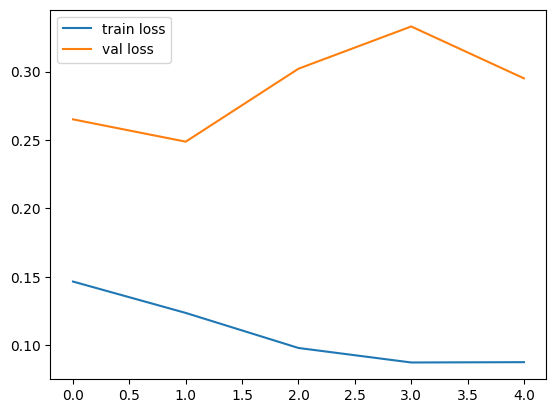

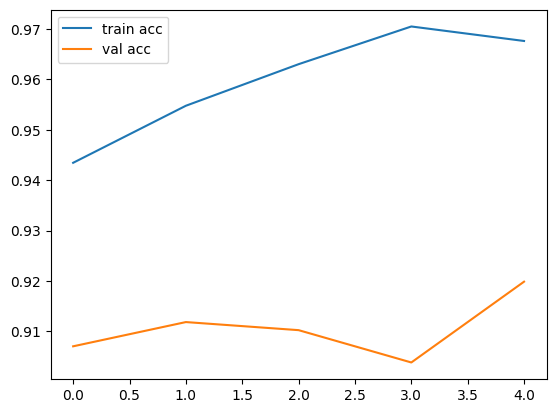

In [22]:
plt.plot(r.history['loss'], label='train loss')
plt.plot(r.history['val_loss'], label='val loss')
plt.legend()
plt.show()

# plot the accuracy
plt.plot(r.history['accuracy'], label='train acc')
plt.plot(r.history['val_accuracy'], label='val acc')
plt.legend()
plt.show()

In [18]:
import tensorflow as tf

from keras.models import load_model

model.save('lung_vgg16.h5')

c:\Users\Yash\.conda\envs\asrmr\lib\site-packages\keras\src\engine\training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [42]:
validation_set = test_datagen.flow_from_directory('Datasets/test', target_size=(224, 224), batch_size=32, class_mode='categorical')

Found 624 images belonging to 2 classes.


In [43]:
    r = model.fit_generator(
        training_set,
        validation_data=validation_set,
        epochs=5,
        steps_per_epoch=len(training_set),
        validation_steps=len(validation_set)
    )

TypeError: fit_generator() missing 1 required positional argument: 'generator'

In [41]:
import streamlit as st
from PIL import Image
import numpy as np
from keras.models import load_model
from tensorflow.keras.applications.vgg16 import preprocess_input
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.vgg16 import VGG16, decode_predictions

# Load the VGG16 model
model = load_model('lung_vgg16.h5')

def preprocess_image(img):
    # Resize image to the input size expected by VGG16 (224x224 pixels)
    img = Image.open(image_path)

    # Resize the image to 224x224 pixels
    img = img.resize((224, 224))
    
    # Convert the image to RGB
    img = img.convert('RGB')
    
    # Convert the image to a NumPy array
    img_array = image.img_to_array(img)

    # Add an extra dimension and preprocess the image
    img_array = np.expand_dims(img_array, axis=0)
    img_array = preprocess_input(img_array)

    return img_array

def output(processed_image, model):
    # Perform inference
    predictions = model.predict(processed_image)
    
    return predictions


# Upload image through Streamlit
image_path = r'chest_xray/chest_xray/val/PNEUMONIA/person1954_bacteria_4886.jpeg'
img = Image.open(image_path)

# Display the uploaded image
# img.show()

# Process the image
processed_image = preprocess_image(img)
        
# Model inference
model_output = output(processed_image, model)

# Display model output
print(model_output)

predicted_probabilities = model_output[0]

# Determine the predicted class based on the highest probability
predicted_class = "Pneumonia Confirmed" if predicted_probabilities[1] > predicted_probabilities[0] else "Normal patient"

# Display the final prediction
print(predicted_class)

# r"chest_xray/chest_xray/val/NORMAL/NORMAL2-IM-1442-0001.jpeg"

1/1 [==============================] - 0s 288ms/step
[[8.632611e-32 1.000000e+00]]
Pneumonia Confirmed
